## Importing and Processing Data

In [44]:
import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from PIL import Image
import os

In [2]:
path="../dataset/face_age/"

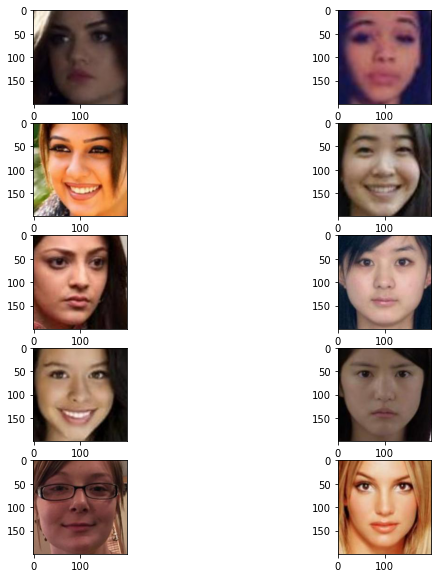

In [3]:
# Visualization of images

def visualize_image(age, number_of_images):
    plt.figure(figsize=(10, 10))
    folder=path+age+'/'
    images=os.listdir(folder)[:number_of_images]
    for i in range(number_of_images):
        img=mpimg.imread(folder+images[i])
        plt.subplot(number_of_images//2, 2, i+1)
        plt.imshow(img)

visualize_image("020", 10)

In [4]:
X=[]
y=[]

for folder, _, imgs in os.walk(path):
    if folder!="face_age":
        for img in imgs:
            img_path=folder+'/'+img
            image=Image.open(img_path)
            image=image.convert('L') #gray-scale images
            X.append(np.array(image))
            y.append(int(folder[-3:]))

X=np.array(X)
y=np.array(y);

In [5]:
len(X)

19556

In [6]:
X=X.astype("float32")
#normalization
X /= 255.0
y = y//5

In [7]:
X = X.reshape(X.shape[0], 200, 200, 1)
X.shape

(19556, 200, 200, 1)

In [8]:
# os.mkdir("../dataset/Data")

In [9]:
# np.save("../dataset/face_age_data/X.npy", X)
# np.save("../dataset/face_age_data/y.npy", y)
# X = np.load('../dataset/face_age_data/X.npy')
# y = np.load('../dataset/face_age_data/y.npy')

## Train, Test and Validation Datasets

In [10]:
# Train, validation and testing split (70/15/15)

test_size = 0.3
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [11]:
# save to files
# np.save('../dataset/face_age_data/X_train.npy', X_train)
# np.save('../dataset/face_age_data/y_train.npy', y_train)
# np.save('../dataset/face_age_data/X_val.npy', X_val)
# np.save('../dataset/face_age_data/y_val.npy', y_val)
# np.save('../dataset/face_age_data/X_test.npy', X_test)
# np.save('../dataset/face_age_data/y_test.npy', y_test)

# X_train = np.load('../dataset/face_age_data/X_train.npy')
# y_train = np.load('../dataset/face_age_data/y_train.npy')
# X_val = np.load('../dataset/face_age_data/X_val.npy')
# y_val = np.load('../dataset/face_age_data/y_val.npy')
# X_test = np.load('../dataset/face_age_data/X_test.npy')
# y_test = np.load('../dataset/face_age_data/y_test.npy')

In [12]:
# confirm the saved files
# os.listdir("../face_age_dataset/Data")

## Image Augmentation

In [13]:
# Apply Image Augmentation

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

## Callbacks and Default Hyperparameters

In [14]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't increase (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

        
# hyperparameters
lr = 0.01
epochs = 50
batch_size = 128
results = {}
input_shape =[200, 200]

## Simple CNN Model

* A simple CNN model with 6 layers:
Input - Conv - MaxPool - Dropout - Flatten - Output

In [15]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",
                   padding="valid",
                   kernel_regularizer=regularizers.l2(0.00001),
                   input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1,activation="linear")) 
    return model

In [16]:
filepath = 'checkpoints/cnn_face-age__relu.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="min", verbose=1)

In [17]:
# Adam= keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9, beta_2=0.999, decay=0.0)

In [18]:
model = baseline_model()
model.compile(optimizer="adam", loss="mse", metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 1)                 313633    
                                                                 
Total params: 313,953
Trainable params: 313,953
Non-trainable params: 0
__________________________________________________

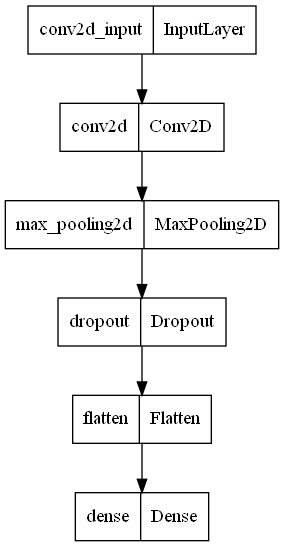

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='models/cnn_facial_age-relu.png')

In [20]:
model.fit(
    train_datagen.flow(
        X_train, y_train,
        batch_size = batch_size
    ), # use augmented images
    validation_data = (X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs = epochs,
    callbacks = [
                    reduce_learning_rate,
                    early_stopping,
                    time_callback,
                    checkpoint
                ],
    verbose=True)

Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 24.7521 - mae: 3.9709
Epoch 00001: val_loss improved from inf to 13.06587, saving model to checkpoints\cnn_face-age__relu.epoch01-loss13.07.hdf5
106/106 [==============================] - 255s 2s/step - loss: 24.7521 - mae: 3.9709 - val_loss: 13.0659 - val_mae: 2.8035 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - ETA: 0s - loss: 13.6792 - mae: 2.9340
Epoch 00002: val_loss improved from 13.06587 to 10.67036, saving model to checkpoints\cnn_face-age__relu.epoch02-loss10.67.hdf5
106/106 [==============================] - 232s 2s/step - loss: 13.6792 - mae: 2.9340 - val_loss: 10.6704 - val_mae: 2.5095 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - ETA: 0s - loss: 12.0724 - mae: 2.7235
Epoch 00003: val_loss improved from 10.67036 to 10.35478, saving model to checkpoints\cnn_face-age__relu.epoch03-loss10.35.hdf5
106/106 [==============================] - 201s 2s/step - loss: 12.0724

In [21]:
baseline_adam_train_loss = model.history.history["loss"]
baseline_adam_val_loss = model.history.history["val_loss"]
baseline_adam_train_acc = model.history.history["mae"]
baseline_adam_val_acc = model.history.history["val_mae"]

results["baseline_adam"] = {'train-loss': baseline_adam_train_loss,
                             'val-loss': baseline_adam_val_loss,
                             'train-mae': baseline_adam_train_acc,
                             'val-mae': baseline_adam_val_acc}

## Performance Visualization

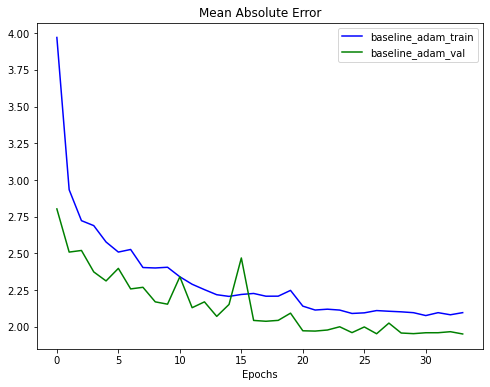

In [22]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train", color="blue")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '-', label=cond+"_val", color="green")
plt.title("Mean Absolute Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results on Test Set
#### Loss: 9.50348114113819
#### Mean Absolute Error: 9.503398895263672

In [23]:
model_test_results = model.evaluate(X_test, y_test, batch_size=128)
dict(zip(model.metrics_names, model_test_results))

23/23 [==============================] - 7s 318ms/step - loss: 7.1645 - mae: 2.0252


{'loss': 7.164482116699219, 'mae': 2.0251657962799072}

In [39]:
y_pred = model.predict(X).reshape(-1)

## Dividing in various Age Ranges

In [40]:
y_pred_range=np.round((y_pred), 0).astype(int)
float(100*sum(np.equal(y, y_pred_range).astype(int))/len(y_pred_range))

16.69052976068726

Text(0.5, 1.0, 'Predicted vs Original')

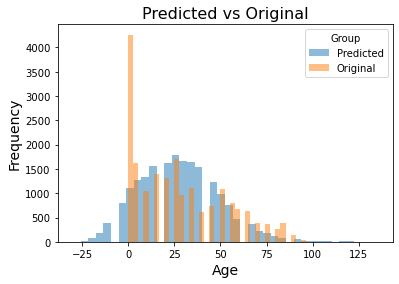

In [43]:
pd.Series((5 * y_pred_range.reshape((len(y_pred))))).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series((5 * y)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

<AxesSubplot:>

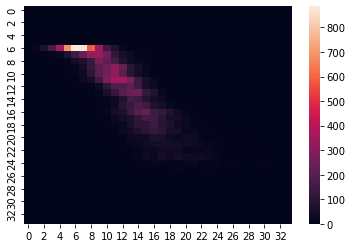

In [46]:
import seaborn as sns
sns.heatmap(confusion_matrix(y, y_pred_range))

In [50]:
print(classification_report(y, y_pred_range))

              precision    recall  f1-score   support

          -6       0.00      0.00      0.00         0
          -5       0.00      0.00      0.00         0
          -4       0.00      0.00      0.00         0
          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.80      0.21      0.33      4262
           1       0.18      0.14      0.16      1630
           2       0.10      0.12      0.11      1042
           3       0.14      0.15      0.14      1394
           4       0.16      0.20      0.18      1322
           5       0.19      0.20      0.20      1712
           6       0.11      0.19      0.14       960
           7       0.15      0.22      0.18      1108
           8       0.09      0.23      0.13       608
           9       0.12      0.20      0.15       742
          10       0.14      0.13      0.14      1078
          11       0.13    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
